# **PROJECT: IMAGE CLASSIFICATION**

In [76]:
import numpy as np
import pandas as pd

import os
import cv2
import json

from google.colab.patches import cv2_imshow
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
from google.colab import files

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.nn.utils import clip_grad_norm_

Mounted at /content/drive


# **Computer vison** ✅

In [77]:
file_path = "/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/annotations.csv"
df = pd.read_csv(file_path)
df

,filename,label
0,kirmizi (1).jpg,0
1,kirmizi (10).jpg,0
2,kirmizi (11).jpg,0
3,kirmizi (12).jpg,0
4,kirmizi (13).jpg,0
...,...,...
2143,siirt 95.jpg,1
2144,siirt 96.jpg,1
2145,siirt 97.jpg,1
2146,siirt 98.jpg,1


In [78]:
# for i in image_feature:
#   a = os.path.join("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Kirmizi_Pistachio", i)
#   print(cv2.imread(a).shape)
#   b = cv2.resize(cv2.imread(a), (128, 128))
#   print(b.shape)
#   print(b.flatten().shape)
#   print(b.flatten().reshape(1, -1).shape)
#   print(np.unique(b))
#   print(b.dtype)
#   break

In [79]:
annotations = {}
image_feature = []
train_images = []
train_labels = []

for i in df["filename"]:
  image_feature.append(i)
  if "kirmizi" in i:
      annotations[i] = {"label": "kirmizi"}
  elif "siirt" in i:
      annotations[i] = {"label": "siirt"}


for i in df["label"]:
    train_labels.append(i)


path_1, path_2 = "/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Kirmizi_Pistachio", "/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Siirt_Pistachio"
for i in image_feature:
  read_path = os.path.join(path_1, i) if i in os.listdir(path_1) else os.path.join(path_2, i)
  if os.path.exists(read_path):
    image = cv2.imread(read_path)
    image = cv2.resize(image, (128, 128))
    train_images.append(image)

In [80]:
train_images = np.array(train_images).astype("float32")
train_labels = np.array(train_labels).reshape(-1, 1).astype(int)

In [81]:
X = train_images
y = train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 3 * 128 * 128)
X_test = X_test.reshape(X_test.shape[0], -1)

knn = cv2.ml.KNearest_create()
knn.train(X_train, cv2.ml.ROW_SAMPLE, y_train)

k_values = [1, 2, 3, 4, 5]
confusion_matrix_list = []
for k in k_values:
  ret, result, neighbours, dist = knn.findNearest(X_test, k=k)
  confusion_matrix_list.append(confusion_matrix(y_test, result))
  print(f"The accuracy of k = {k} is {accuracy_score(y_test, result):.2f}")

print("\n")
for i in confusion_matrix_list:
  print(i)

The accuracy of k = 1 is 0.80
The accuracy of k = 2 is 0.82
The accuracy of k = 3 is 0.83
The accuracy of k = 4 is 0.83
The accuracy of k = 5 is 0.83


[[183  61]
 [ 23 163]]
[[208  36]
 [ 42 144]]
[[191  53]
 [ 18 168]]
[[196  48]
 [ 27 159]]
[[188  56]
 [ 18 168]]


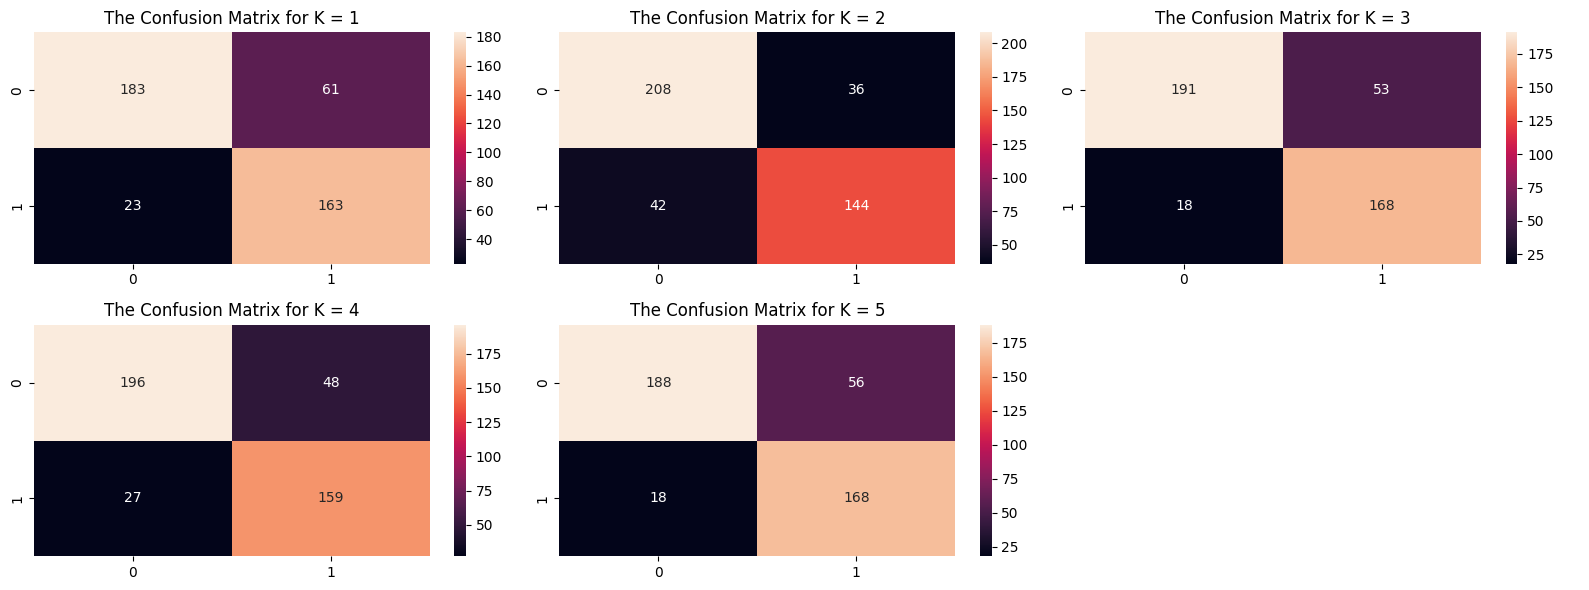

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))

for i, (matrix, k) in enumerate(zip(confusion_matrix_list[:3], k_values[:3])):
  sns.heatmap(pd.DataFrame(matrix), annot=True, fmt="d" ,ax=axes[0, i])
  axes[0, i].set_title(f"The Confusion Matrix for K = {k}")

for i, (matrix, k) in enumerate(zip(confusion_matrix_list[3:5], k_values[3:5])):
  sns.heatmap(pd.DataFrame(matrix), annot=True, fmt="d", ax=axes[1, i])
  axes[1, i].set_title(f"The Confusion Matrix for K = {k}")

for ax in axes.flat:
  if not ax.has_data():
    ax.axis('off')

plt.tight_layout()
plt.show()

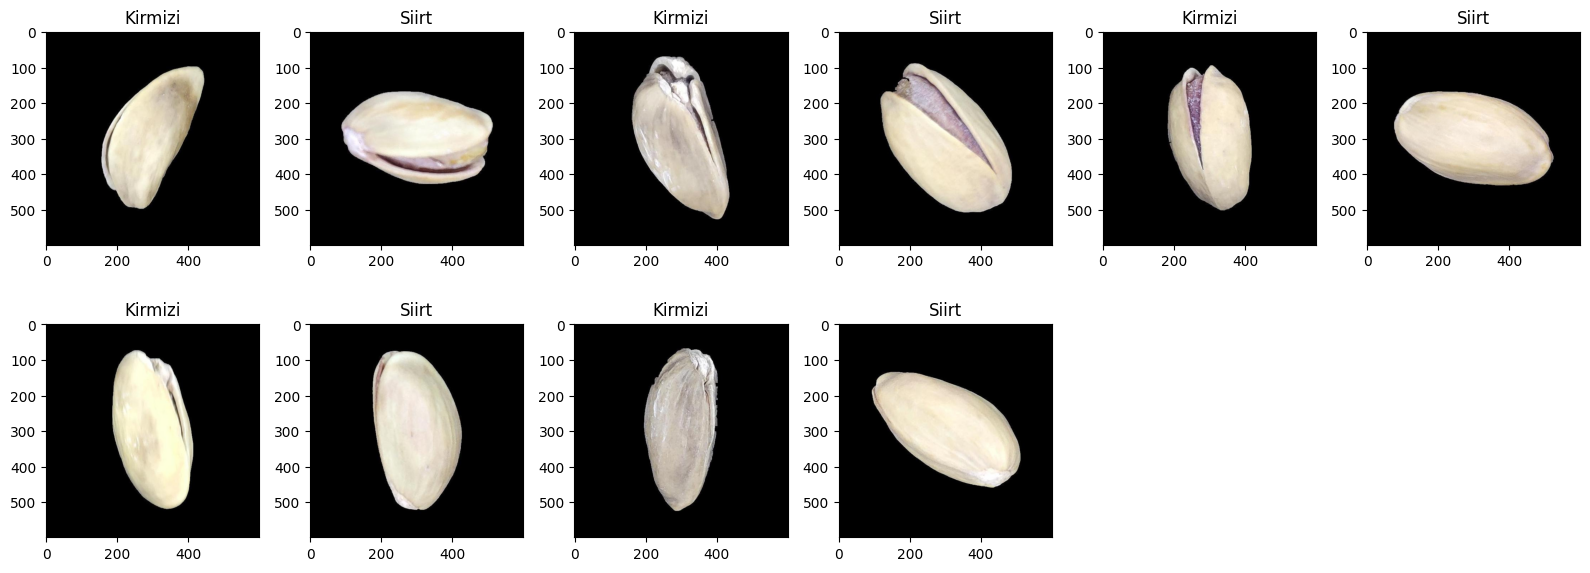

In [83]:
fig, axes = plt.subplots(2, 6, figsize=(16, 6))

for i, (ki, si) in enumerate(zip(os.listdir(path_1)[:3], os.listdir(path_2)[:3])):
  axes[0, 2 * i].imshow(cv2.cvtColor(cv2.imread(os.path.join(path_1, ki)), cv2.COLOR_BGR2RGB))
  axes[0, 2 * i].set_title("Kirmizi")
  axes[0, 2 * i + 1].imshow(cv2.cvtColor(cv2.imread(os.path.join(path_2, si)), cv2.COLOR_BGR2RGB))
  axes[0, 2 * i + 1].set_title("Siirt")


for i, (ki, si) in enumerate(zip(os.listdir(path_1)[10:12], os.listdir(path_2)[3:5])):
  axes[1, 2 * i].imshow(cv2.cvtColor(cv2.imread(os.path.join(path_1, ki)), cv2.COLOR_BGR2RGB))
  axes[1, 2 * i].set_title("Kirmizi")
  axes[1, 2 * i + 1].imshow(cv2.cvtColor(cv2.imread(os.path.join(path_2, si)), cv2.COLOR_BGR2RGB))
  axes[1, 2 * i + 1].set_title("Siirt")


for ax in axes.flat:
  if not ax.has_data():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [84]:
knn.save(os.path.join("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/", "knn_model.yml"))

In [109]:
knn = cv2.ml.KNearest_load(os.path.join("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/", "knn_model.yml"))

def predict_label(image_path):
    read_path = os.path.join(path_1, image_path) if image_path in os.listdir(path_1) else os.path.join(path_2, image_path)
    if os.path.exists(read_path):
      image = cv2.cvtColor(cv2.imread(read_path), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (128, 128))
      image = image.flatten().reshape(1, -1).astype("float32")
      ret, result, neighbours, dist = knn.findNearest(image, k=3)
      return  result, "Kirmizi" if result[0][0] == 0 else "Siirt"

image_test = predict_label("kirmizi (40).jpg")
print(image_test[0])
print(f"Predict Label: {image_test[1]}")

[[0.]]
Predict Label: Kirmizi


In [86]:
# file_up = files.upload()
# knn = cv2.ml.KNearest_load(os.path.join("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/", "knn_model.yml"))

# def predict_label(image_path):
#     read_path = os.path.join(path_1, image_path) if image_path in os.listdir(path_1) else os.path.join(path_2, image_path)
#     if os.path.exists(read_path):
#       image = cv2.cvtColor(cv2.imread(read_path), cv2.COLOR_BGR2RGB)
#       image = cv2.resize(image, (128, 128))
#       image = image.flatten().reshape(1, -1).astype("float32")
#       ret, result, neighbours, dist = load_knn.findNearest(image, k=3)
#       return  result, "Kirmizi" if result[0][0] == 0 else "Siirt"

# image_test = predict_label("kirmizi (30).jpg")
# print(image_test[0])
# print(f"Predict Label: {image_test[1]}")

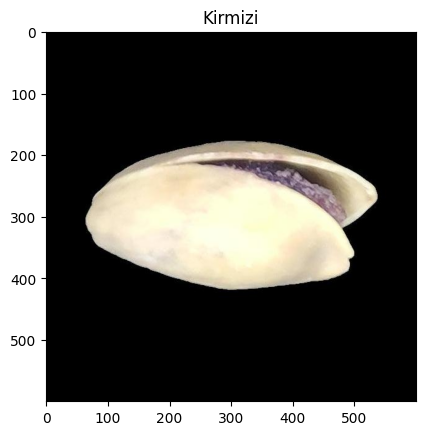

In [110]:
read_path = os.path.join(path_1, "kirmizi (40).jpg")
if os.path.exists(read_path):
  image = cv2.cvtColor(cv2.imread(read_path), cv2.COLOR_BGR2RGB)
  plt.title("Kirmizi")
  plt.imshow(image)
plt.show()

# **Machine learning (check Yhat and Accuracy vs Deep learning)** ✅

In [88]:
df_ml = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Pistachio_28_Features_Dataset.csv")

In [89]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           2148 non-null   int64  
 1   Perimeter      2148 non-null   float64
 2   Major_Axis     2148 non-null   float64
 3   Minor_Axis     2148 non-null   float64
 4   Eccentricity   2148 non-null   float64
 5   Eqdiasq        2148 non-null   float64
 6   Solidity       2148 non-null   float64
 7   Convex_Area    2148 non-null   int64  
 8   Extent         2148 non-null   float64
 9   Aspect_Ratio   2148 non-null   float64
 10  Roundness      2148 non-null   float64
 11  Compactness    2148 non-null   float64
 12  Shapefactor_1  2148 non-null   float64
 13  Shapefactor_2  2148 non-null   float64
 14  Shapefactor_3  2148 non-null   float64
 15  Shapefactor_4  2148 non-null   float64
 16  Mean_RR        2148 non-null   float64
 17  Mean_RG        2148 non-null   float64
 18  Mean_RB 

In [90]:
df_ml_copy = df_ml.copy()
df_ml_copy["Class"] = df_ml_copy["Class"].apply(lambda x: 1 if x == "Kirmizi_Pistachio" else 0)

X = df_ml_copy.drop(["Area", "Class"], axis = 1)
y = df_ml_copy["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))

0.9325581395348838


In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       186
           1       0.95      0.93      0.94       244

    accuracy                           0.93       430
   macro avg       0.93      0.93      0.93       430
weighted avg       0.93      0.93      0.93       430



# **Deep learning** ✅

In [92]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/annotations.csv")

,filename,label
0,kirmizi (1).jpg,0
1,kirmizi (10).jpg,0
2,kirmizi (11).jpg,0
3,kirmizi (12).jpg,0
4,kirmizi (13).jpg,0
...,...,...
2143,siirt 95.jpg,1
2144,siirt 96.jpg,1
2145,siirt 97.jpg,1
2146,siirt 98.jpg,1


In [93]:
pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Pistachio_28_Features_Dataset.csv")

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
0,63391,1568.4050,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,...,17.7206,19.6024,21.1342,0.4581,0.6635,0.7591,2.9692,3.0576,2.9542,Kirmizi_Pistachio
1,68358,1942.1870,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,...,26.7061,27.2112,25.1035,-0.3847,-0.2713,-0.2927,1.9807,2.1006,2.2152,Kirmizi_Pistachio
2,73589,1246.5380,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,...,19.0129,20.0703,20.7006,-0.6014,-0.4500,0.2998,3.5420,3.6856,4.1012,Kirmizi_Pistachio
3,71106,1445.2610,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,...,18.1773,18.7152,29.7883,-0.6943,-0.6278,-0.7798,2.8776,2.8748,2.8953,Kirmizi_Pistachio
4,80087,1251.5240,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,...,23.4298,24.0878,23.1157,-0.9287,-0.8134,-0.4970,2.9915,2.8813,2.7362,Kirmizi_Pistachio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,85983,1157.1160,444.3447,248.8627,0.8284,330.8730,0.9823,87536,0.6799,1.7855,...,20.8474,20.8118,21.1175,-0.6994,-0.7071,-0.6963,2.8853,2.6599,2.6317,Siirt_Pistachio
2144,85691,2327.3459,439.8794,278.9297,0.7732,330.3107,0.8886,96439,0.6590,1.5770,...,21.2621,22.5004,21.5821,-0.5567,-0.4968,-0.6597,2.3022,2.2664,2.5161,Siirt_Pistachio
2145,101136,1255.6190,475.2161,271.3299,0.8210,358.8459,0.9888,102286,0.7584,1.7514,...,21.1262,20.0279,17.4401,-0.9072,-0.8790,-0.4470,3.3112,3.4306,3.0697,Siirt_Pistachio
2146,97409,1195.2150,452.1823,274.5764,0.7945,352.1718,0.9902,98376,0.7635,1.6468,...,19.3274,19.1782,19.8930,-0.9473,-0.8404,-0.3153,3.4237,2.9606,3.0033,Siirt_Pistachio


In [94]:
class Image_Feature(Dataset):
  def __init__(self, dir, path_1, path_2):
    self.df = pd.read_csv(dir)
    self.images = self.df["filename"]
    self.path_1 = path_1
    self.path_2 = path_2
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    read_path = os.path.join(self.path_1, self.images.iloc[index]) if self.images.iloc[index] in os.listdir(self.path_1) else os.path.join(self.path_2, self.images.iloc[index])
    image = None
    if os.path.exists(read_path):
      image = cv2.cvtColor(cv2.imread(read_path), cv2.COLOR_BGR2RGB)

    return image


class Numerical_Feature(Dataset):
  def __init__(self, dir):
    self.df = pd.read_csv(dir)
    self.length = self.df.shape[0]
    self.data = self.df.drop(["Area", "Class"], axis = 1)
  def __len__(self):
    return self.length
  def __getitem__(self, index):
    data = self.data.iloc[index].values
    return data


class Combined_Image_Numeric(Dataset):
  def __init__(self, data_1, data_2, dir, transform = None):
    self.data_1 = data_1
    self.data_2 = data_2
    self.dir = pd.read_csv(dir)
    self.label = self.dir["Class"]
    self.transform = transform
  def __len__(self):
    return len(self.data_1)
  def __getitem__(self, index):
    image = self.data_1[index]
    numeric = self.data_2[index]
    label = self.label[index]
    label = 0 if label == "Kirmizi_Pistachio" else 1

    if self.transform:
      image = self.transform(image)

    numeric = torch.tensor(numeric, dtype= torch.float32)
    label = torch.tensor(label, dtype= torch.long)
    return image, numeric, label


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

compose_rotate = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomAffine(45),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

file_1 = Image_Feature("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/annotations.csv", path_1, path_2)
file_2 = Numerical_Feature("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Pistachio_28_Features_Dataset.csv")

scaler = StandardScaler()
numeric_scaler = scaler.fit_transform(file_2.data)

my_data = Combined_Image_Numeric(file_1, numeric_scaler, "/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Pistachio_28_Features_Dataset.csv", transform)
my_data_rotate = Combined_Image_Numeric(file_1, numeric_scaler, "/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/Pistachio_28_Features_Dataset.csv", transform = compose_rotate)

train_data, test_data = train_test_split(my_data, test_size = 0.2, shuffle=True, random_state=42)
train_data_rotate, val_data_rotate = train_test_split(my_data_rotate, test_size = 0.2, shuffle=True, random_state=42)

train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

val_data_rotate = DataLoader(val_data_rotate, batch_size = 10, shuffle=False)

In [95]:
# class CNN_For_Image(nn.Module):
#   def __init__(self):
#     super(CNN_For_Image, self).__init__()
#     self.image_layers = nn.Sequential(
#         nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2),   # 64

#         nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2),   # 32

#         nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2),   # 16
#     )

#     self.fc_layers = nn.Sequential(
#         nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
#     )
#     self.numeric_layers = nn.Sequential(
#         nn.Linear(27, 128),
#         nn.ReLU()
#     )

#     self.combined_layers = nn.Sequential(
#         nn.Linear(256, 64), nn.ReLU(),
#         nn.Linear(64, 1)
#     )

#     self.apply(self._init_weights)
#   def _init_weights(self, m):
#       if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#           nn.init.constant_(m.bias, 0)

#   def forward(self, image, numeric):
#     x1 = self.image_layers(image)
#     x1 = x1.view(x1.size(0), -1)
#     x1 = self.fc_layers(x1)

#     x2 = self.numeric_layers(numeric)

#     x = torch.cat((x1, x2), dim=1)
#     x = self.combined_layers(x)
#     return x

class CNN_For_Image(nn.Module):
    def __init__(self):
        super(CNN_For_Image, self).__init__()
        self.cnn1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.cnn2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.cnn3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
        )

        self.numeric_layers = nn.Sequential(
            nn.Linear(27, 128), nn.ReLU()
        )
        self.combined_layers = nn.Sequential(
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, image, numeric):
        x1 = self.maxpool(torch.relu(self.cnn1(image)))
        x1 = self.maxpool(torch.relu(self.cnn2(x1)))
        x1 = self.maxpool(torch.relu(self.cnn3(x1)))

        x1 = x1.view(x1.size(0), -1)
        x1 = self.fc_layers(x1)

        x2 = self.numeric_layers(numeric)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_layers(x)
        return x

    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out1 = self.maxpool(a1)
        out_flat = out1.view(out1.size(0), -1)
        return z1, a1, out1, out_flat


model = CNN_For_Image()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model.train()
for epoch in range(10):
  current_loss = 0
  for i, (image, numeric, label) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(image, numeric)
    loss = criterion(output, label.unsqueeze(1).float())
    loss.backward()
    clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    current_loss += loss.item()
    if i % 34 == 33:
      print(f"The loss of epoch {epoch + 1}, batch {i + 1}: {current_loss / 34:.2f}")
      current_loss = 0
  scheduler.step()
  torch.cuda.empty_cache()

torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/", "model_save.pt"))

The loss of epoch 1, batch 34: 0.43
The loss of epoch 1, batch 68: 0.24
The loss of epoch 1, batch 102: 0.16
The loss of epoch 1, batch 136: 0.24
The loss of epoch 1, batch 170: 0.18
The loss of epoch 2, batch 34: 0.14
The loss of epoch 2, batch 68: 0.10
The loss of epoch 2, batch 102: 0.15
The loss of epoch 2, batch 136: 0.15
The loss of epoch 2, batch 170: 0.17
The loss of epoch 3, batch 34: 0.11
The loss of epoch 3, batch 68: 0.10
The loss of epoch 3, batch 102: 0.10
The loss of epoch 3, batch 136: 0.09
The loss of epoch 3, batch 170: 0.06
The loss of epoch 4, batch 34: 0.10
The loss of epoch 4, batch 68: 0.09
The loss of epoch 4, batch 102: 0.04
The loss of epoch 4, batch 136: 0.13
The loss of epoch 4, batch 170: 0.03
The loss of epoch 5, batch 34: 0.03
The loss of epoch 5, batch 68: 0.05
The loss of epoch 5, batch 102: 0.10
The loss of epoch 5, batch 136: 0.08
The loss of epoch 5, batch 170: 0.08
The loss of epoch 6, batch 34: 0.05
The loss of epoch 6, batch 68: 0.11
The loss of e

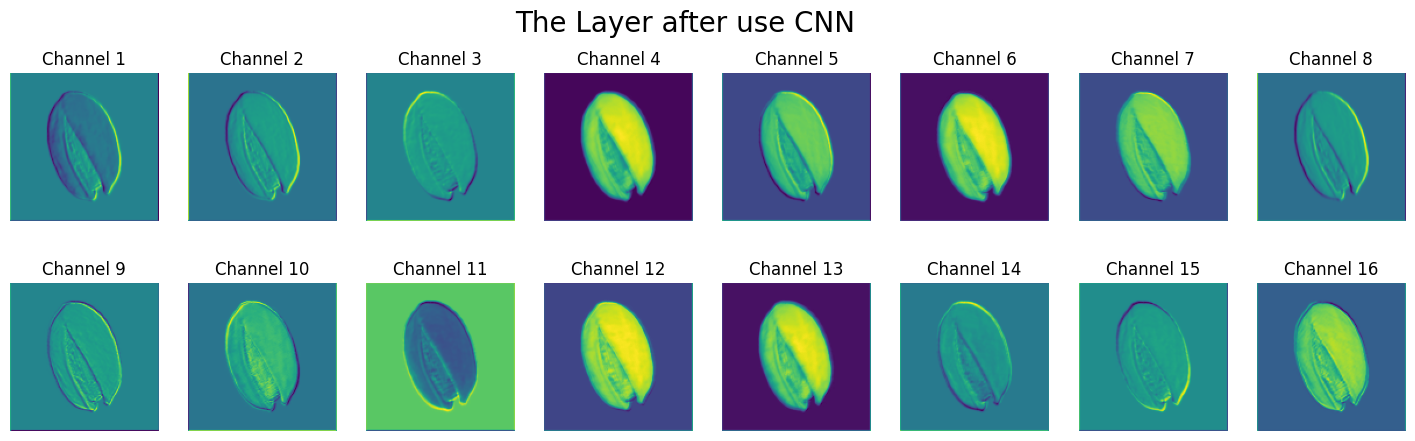

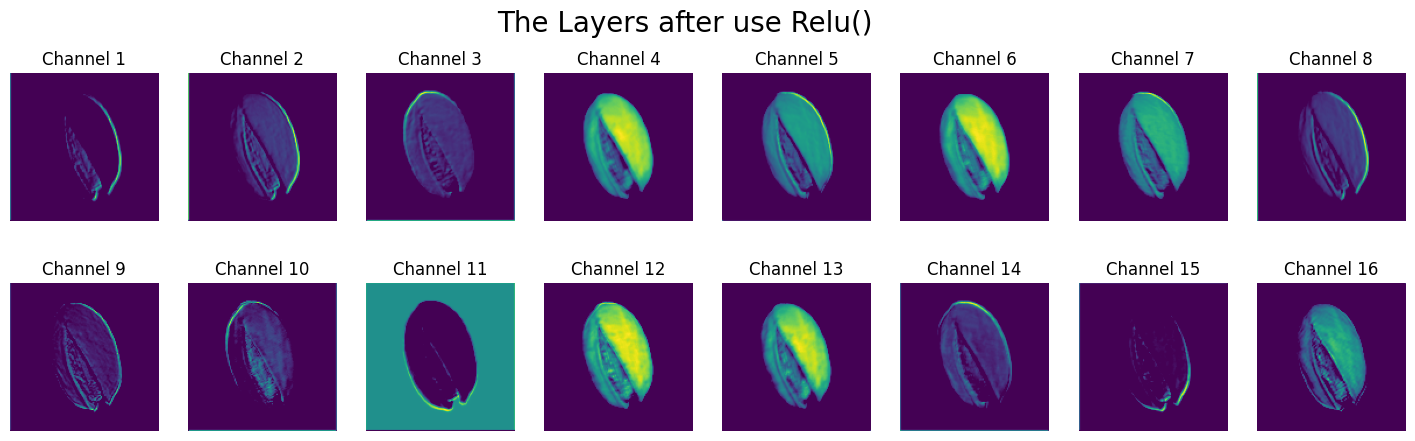

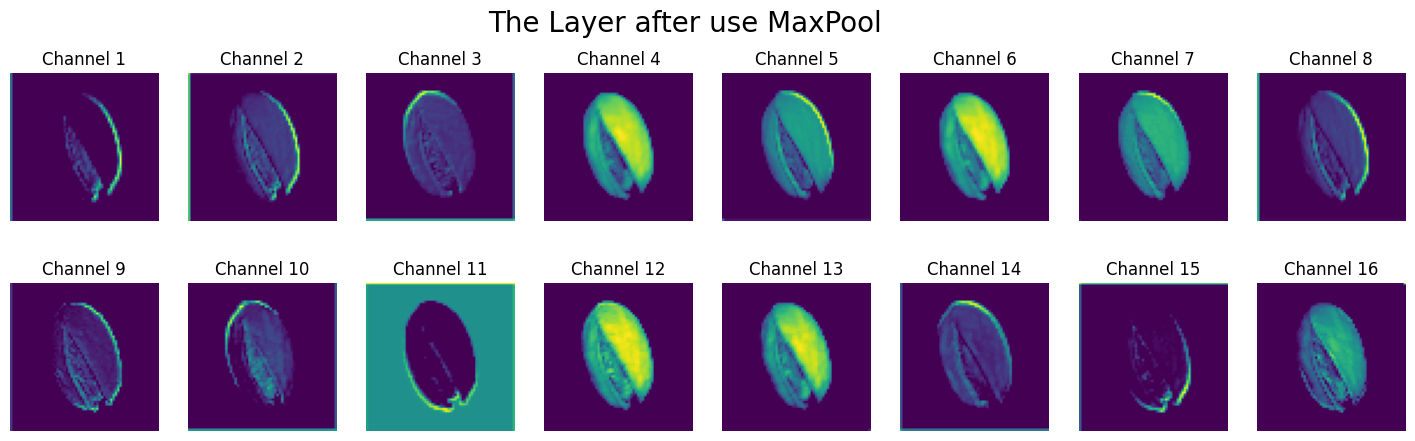

In [96]:
max_display = 1
display_count = 0

for batch_idx, (image, numeric, label) in enumerate(train_loader):
    if display_count >= max_display:
        break
    out = model.activations(image)

    plt.figure(figsize=(18, 5))
    for i in range(out[0].shape[1]):
        plt.subplot(2, 8, i + 1)
        plt.imshow(out[0][0, i, :, :].detach().numpy())
        plt.title(f'Channel {i + 1}')
        plt.axis('off')
    plt.suptitle("The Layer after use CNN", fontsize=20)

    plt.figure(figsize=(18, 5))
    for i in range(out[1].shape[1]):
        plt.subplot(2, 8, i + 1)
        plt.imshow(out[1][0, i, :, :].detach().numpy())
        plt.title(f'Channel {i + 1}')
        plt.axis('off')
    plt.suptitle("The Layers after use Relu()", fontsize=20)

    plt.figure(figsize=(18, 5))
    for i in range(out[2].shape[1]):
        plt.subplot(2, 8, i + 1)
        plt.imshow(out[2][0, i, :, :].detach().numpy())
        plt.title(f'Channel {i + 1}')
        plt.axis('off')
    plt.suptitle("The Layer after use MaxPool", fontsize=20)

    plt.show()
    display_count += 1

The accuracy is: 0.9720930232558139


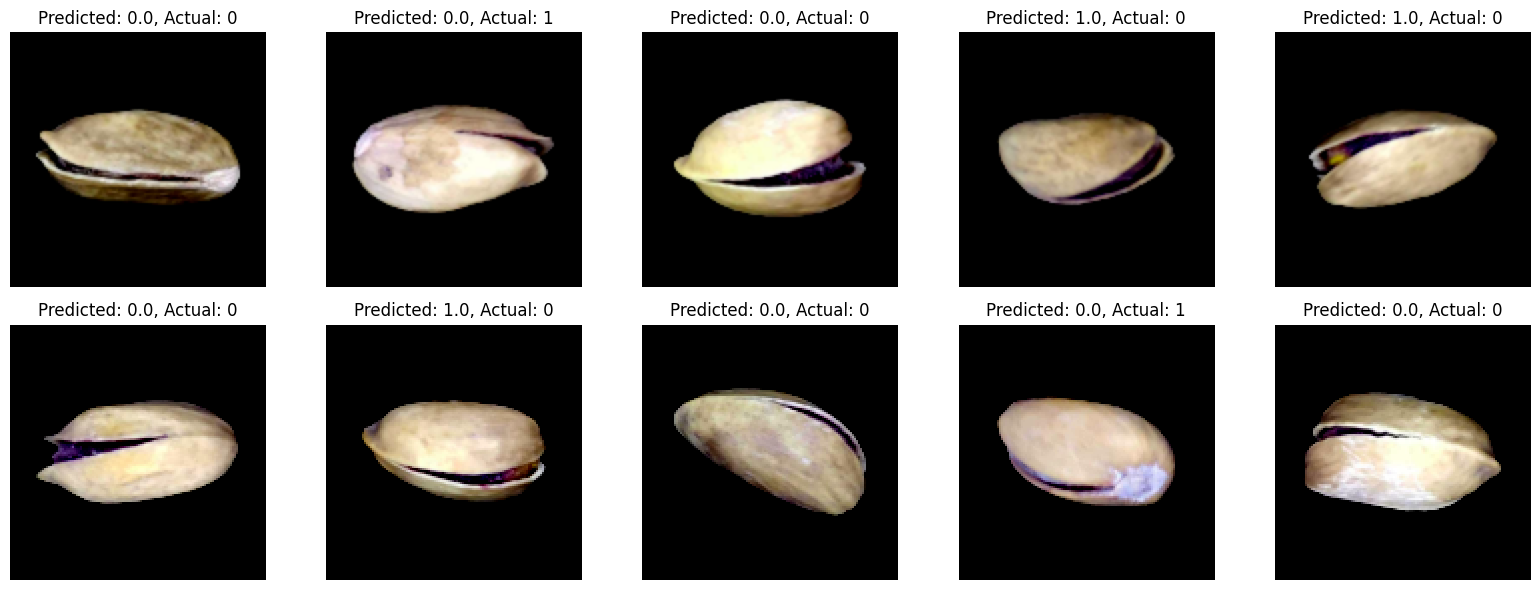

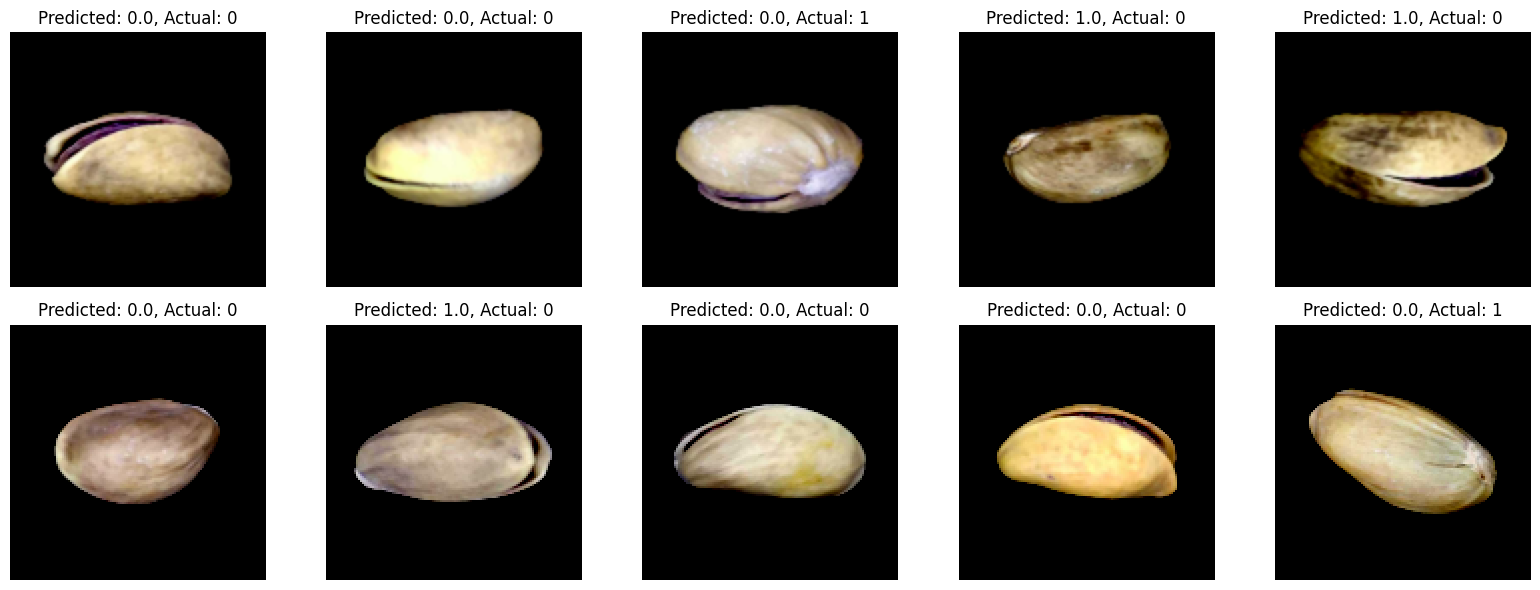

In [105]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  limit_display = 0
  for image, numeric, label in test_loader:
    output = model(image, numeric)
    predicted = torch.round(torch.sigmoid(output))
    total += label.size(0)
    correct += (predicted == label.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f"The accuracy is: {accuracy}") # 96.5%

for image, numeric, label in test_loader:
  if limit_display >= 2:
      break
  plt.figure(figsize = (16, 6))
  for i in range(label.size(0)):
      plt.subplot(2, 5, i + 1)
      img = image[i].permute(2, 1, 0).numpy()
      img = np.clip(img * 255, 0, 255).astype(np.uint8)
      plt.imshow(img)
      plt.title(f"Predicted: {predicted[i].item()}, Actual: {label[i].item()}")
      plt.axis("off")
  plt.tight_layout()
  plt.show()
  limit_display += 1

The accuracy of this model: 0.97


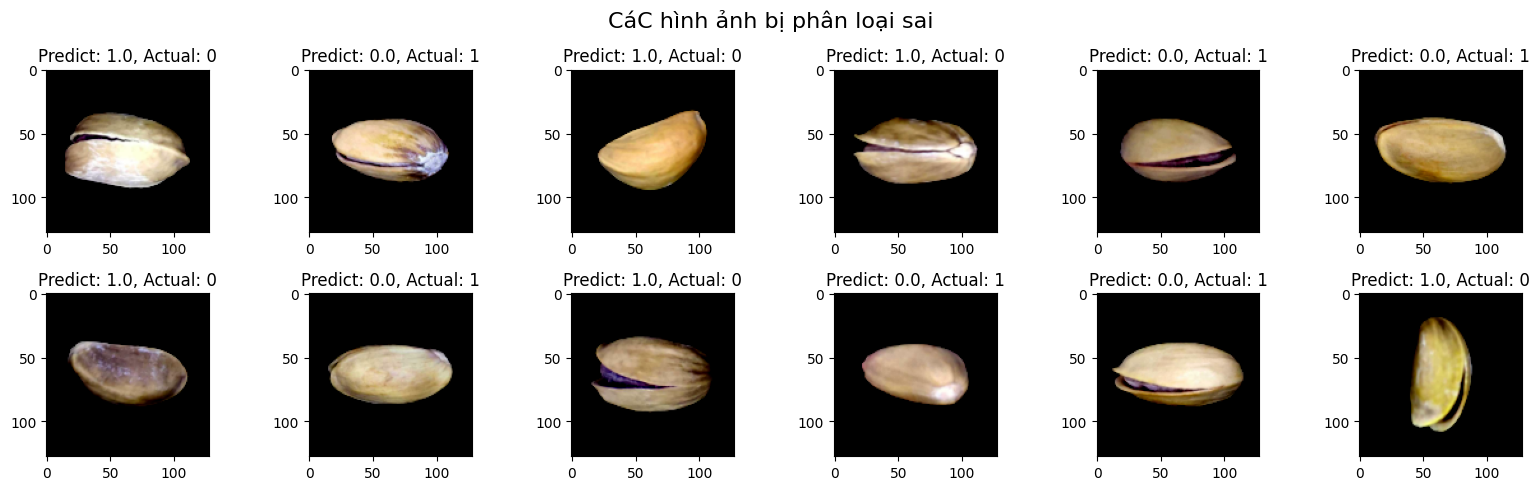

In [98]:
model_r = CNN_For_Image()
model_r.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/model_save.pt", weights_only=True))

model_r.eval()
with torch.no_grad():
    misclassified_indices = []
    misclassified_label = []
    misclassified_predict = []
    correct = 0
    total = 0
    for image, numeric, label in test_loader:  # một batch chứa 10 hình ảnh
        output = model_r(image, numeric)
        predicted = torch.round(torch.sigmoid(output))
        correct += (predicted == label.unsqueeze(1)).sum().item()
        total += label.size(0)

        for i in range(label.size(0)):
          if predicted[i].type(torch.int).item() != label[i].item():
            misclassified_indices.append(image[i])
            misclassified_label.append(label[i])
            misclassified_predict.append(predicted[i])

accuracy = correct / total
print(f"The accuracy of this model: {accuracy:.2f}")

plt.figure(figsize=(16, 7))
for i, (idx, pred, la) in enumerate(zip(misclassified_indices, misclassified_predict, misclassified_label)):
    plt.subplot(3, 6, i + 1)
    img = idx.permute(2, 1, 0).numpy()
    img = np.clip(255 * img, 0, 255).astype(np.uint8)
    plt.title(f"Predict: {pred.item()}, Actual: {la.item()}")
    plt.suptitle("CáC hình ảnh bị phân loại sai", fontsize = 16)
    plt.imshow(img)

plt.tight_layout()
plt.show()

In [99]:
model_rotate = CNN_For_Image()
model_rotate.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/model_save.pt", weights_only=True))

<All keys matched successfully>

 => **Toàn bộ quan sát ở tập kiểm tra với 430 giá trị, có 12 hình ảnh là dự đoán sai**

The accuracy is: 0.9395348837209302


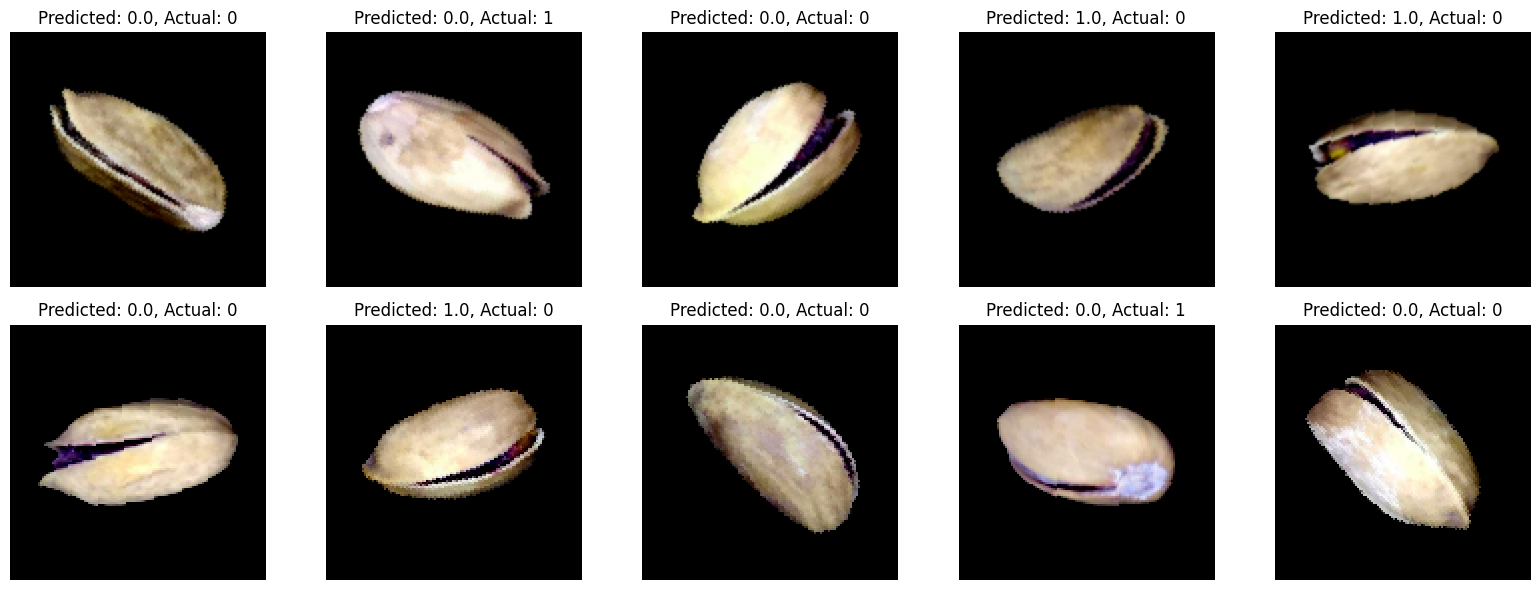

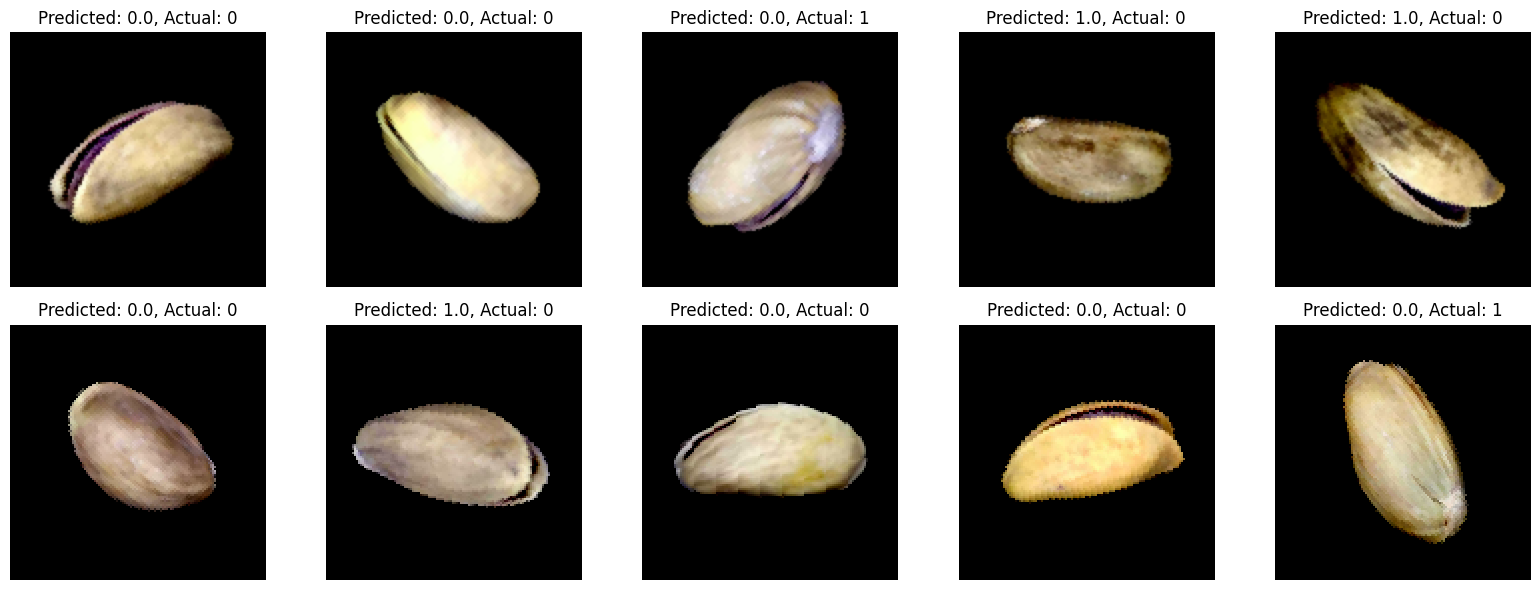

In [106]:
model_rota = CNN_For_Image()
model_rota.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/kirmizi-siirt/model_save.pt", weights_only=True))

model_rota.eval()
with torch.no_grad():
  correct = 0
  total = 0
  limit_display = 0
  for image, numeric, label in val_data_rotate:
    output = model_rota(image, numeric)
    predicted = torch.round(torch.sigmoid(output))
    total += label.size(0)
    correct += (predicted == label.unsqueeze(1)).sum().item()

accuracy = correct / total
print(f"The accuracy is: {accuracy}")

for image, numeric, label in val_data_rotate:
  if limit_display >= 2:
      break
  plt.figure(figsize = (16, 6))
  for i in range(label.size(0)):
      plt.subplot(2, 5, i + 1)
      img = image[i].permute(2, 1, 0).numpy()
      img = np.clip(img * 255, 0, 255).astype(np.uint8)
      plt.imshow(img)
      plt.title(f"Predicted: {predicted[i].item()}, Actual: {label[i].item()}")
      plt.axis("off")
  plt.tight_layout()
  plt.show()
  limit_display += 1

# **The End** ✅